# Quickstart SWYFT

This quickstart guide illustrates how *swyft* can be used to estimate 1-dim and 2-dim marginal posteriors for a simple linear regression model. The same framework can be also used to analyse, e.g., image or other complex data.  The *swfty* API is somewhat verbose right now, which emphasizes the internal workings.  We plan to change this soon.

## Imports

In [57]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [58]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Import swyft
import swyft
DEVICE = swyft.set_device(gpu=True)

## Example 1: linear regression

We consider a simple linear regression problem.  To this end, we define a "line simulator", which produces a line giving two input parameters (offset and slope), and a "noise simulator" that adds Gaussian measurement noise.

In [59]:
def simulator(z):
    "Line simulator"
    p = np.linspace(0, 1, 10)
    offset, slope = z[0], z[1]
    mu = offset + p*slope
    return mu

def noise(mu, z = None, sigma=0.1):
    "Measurement noise simulator"
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return x

### Likelihood-based inference

A traditional $\chi^2$ analysis would now be based on
$$
\chi^2 = -2\ln p(\mathbf{x}_0|\mathbf{z}) = \sum_{i=1}^{N_\text{bins}} \frac{(\mu_i(\mathbf{z}) - x_{0,i})^2}{\sigma^2}
$$
where $\mathbf{x}_0$ referes to the measured flux, $\boldsymbol{\mu}(\mathbf{z})$ is the result of the line simulator model, $\sigma$ refers to the measurement noise (assumed to be Gaussian), and $N_\text{bins} = 10$ is the number of bins.

### Likelihood-free inference

Instead, *swyft* is a simulator based method that works with samples
$$
\mathbf{x}, \mathbf{z} \sim p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})
$$
Note that, for simplicity, *swyft* assumes that all parameters live with uniform prior on the hypercube, i.e. $z_i \in [0, 1]$.

### Simulated data

Let us look at simulated data for some fixed parameters $\mathbf{z} = \mathbf{z}_0$, $\mathbf{x} \sim p(\mathbf{x} | \mathbf{z}_0)$.

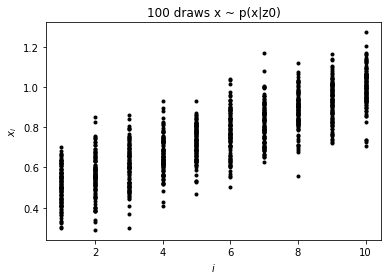

In [60]:
# Fixed parameters
z0 = np.array([0.5, 0.5])

# Simulator and add noise
x_sim = np.array([noise(simulator(z0)) for _ in range(100)]).T
plt.plot(range(1, 11), x_sim, 'k', ls = '', marker = '.')
plt.ylabel("$x_i$")
plt.xlabel("$i$")
plt.title("100 draws x ~ p(x|z0)");

In [61]:
# Define mock data
x0 = noise(simulator(z0))

## Parameter estimation with *swyft* (without nesting)

In [62]:
ZDIM = 2
MAX_EPOCHS = 10
EXPECTED_N = 10000
XSHAPE = (10,)

### 1) Running simulations

We first define a simulation cache. The example problem is simple, and we story simulations simply in memory. We then generate ~1000 simulations, drawn from the uniform prior on the hypercube.

In [63]:
cache = swyft.MemoryCache(zdim = ZDIM, xshape = XSHAPE)
intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N, dim=ZDIM)
cache.grow(intensity)
cache.simulate(simulator)

Simulate:   2%|▏         | 157/9959 [00:00<00:06, 1561.97it/s]

Creating new cache.
Adding 9959 new samples. Run simulator!


Simulate: 100%|██████████| 9959/9959 [00:06<00:00, 1550.12it/s]


### 2) Performing posterior estimation

We then instantiate training data and the ratio estimator, and train the ratio estimator.

In [64]:
# training data
points = swyft.Points(cache, intensity, noise)

In [65]:
# 1-dim posteriors
re = swyft.RatioEstimator(points, device=DEVICE)
re.train(max_epochs=MAX_EPOCHS, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 45.870752573013306
Validation loss: 44.003894567489624
Validation loss: 43.53415489196777
Validation loss: 43.10628008842468
Validation loss: 44.24308252334595
Total epochs: 5
LR iteration 1
Validation loss: 42.451984882354736
Validation loss: 42.97247338294983
Total epochs: 2
LR iteration 2
Validation loss: 43.04813241958618
Validation loss: 43.7719190120697
Total epochs: 2


In [66]:
# 2-dim posteriors
re2dim = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2dim.train(max_epochs=MAX_EPOCHS, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 14.02624648809433
Validation loss: 8.489453360438347
Validation loss: 8.85923045873642
Total epochs: 3
LR iteration 1
Validation loss: 8.632737040519714
Validation loss: 7.62098890542984
Validation loss: 7.334062784910202
Validation loss: 7.0999767780303955
Validation loss: 7.80559042096138
Total epochs: 5
LR iteration 2
Validation loss: 7.558979123830795
Validation loss: 8.07583025097847
Total epochs: 2


### 3) Plotting results

That's all. We plot results.  *swyft* provides convenient functionality for that.

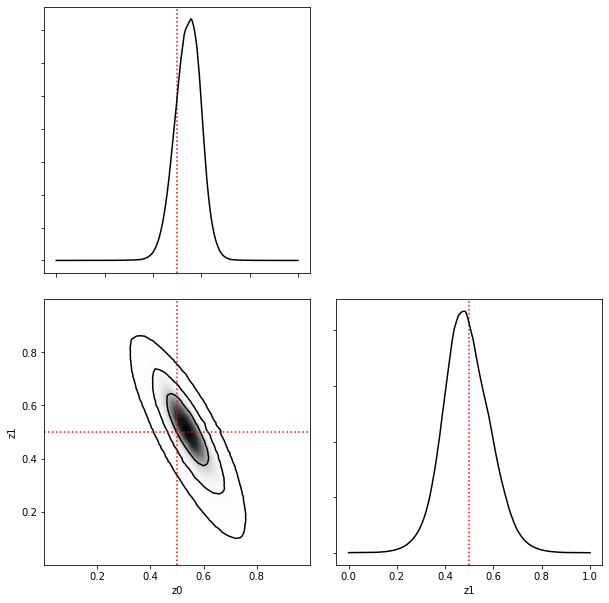

In [76]:
swyft.corner(re, re2dim, x0 = x0*1.0001, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)

## Parameter estimation with *swyft* (nested 2nd round)

### 1) Run simulations on constrained prior

In [68]:
intensity2 = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-5,
        )
cache.grow(intensity2)
cache.simulate(simulator)

Simulate:  19%|█▉        | 160/848 [00:00<00:00, 1592.51it/s]

Constrained posterior area: 0.9183365909159704
Adding 848 new samples. Run simulator!


Simulate: 100%|██████████| 848/848 [00:00<00:00, 1586.25it/s]


### 2) Performing posterior estimation on constrained prior

In [69]:
points2 = swyft.Points(cache, intensity2, noise)
reII = swyft.RatioEstimator(points2, device=DEVICE)
reII.train(max_epochs=MAX_EPOCHS, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 46.98907279968262
Validation loss: 45.802045583724976
Validation loss: 45.41400766372681
Validation loss: 45.41939043998718
Total epochs: 4
LR iteration 1
Validation loss: 44.56027340888977
Validation loss: 44.938095808029175
Total epochs: 2
LR iteration 2
Validation loss: 43.38276958465576
Validation loss: 45.34940242767334
Total epochs: 2


In [70]:
# 2-dim posteriors
reII2dim = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
reII2dim.train(max_epochs=MAX_EPOCHS, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 9.643028259277344
Validation loss: 8.441280126571655
Validation loss: 13.376615822315216
Total epochs: 3
LR iteration 1
Validation loss: 6.174659222364426
Validation loss: 6.874179556965828
Total epochs: 2
LR iteration 2
Validation loss: 6.771594941616058
Validation loss: 6.8468184769153595
Total epochs: 2


### 3) Plotting results

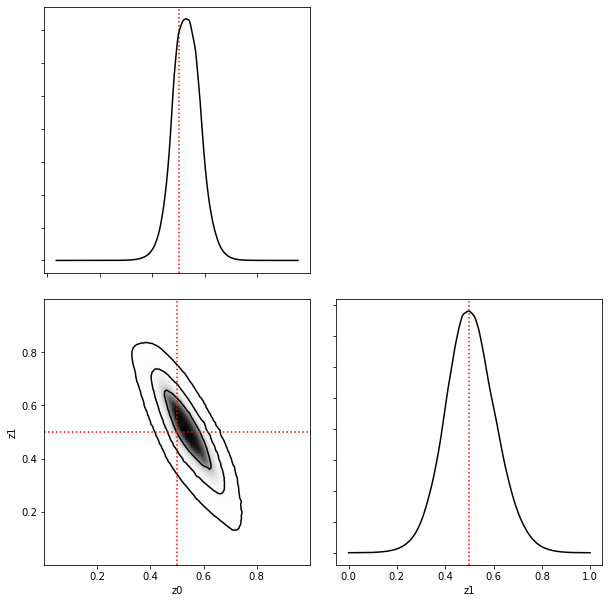

In [75]:
swyft.corner(reII, reII2dim, x0 = x0*1.0001, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)